# Predictive Modeling for Risk Score calculation

### Imports

In [1]:
## Import relevant libraries

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime 

In [2]:
# Stop deprecation warnings from being printed
import warnings
warnings.filterwarnings("ignore")

In [3]:
# packages for logistic regression, naivebayes, KNN, decision tree, random forest

from sklearn.cross_validation import train_test_split

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_curve,auc

from sklearn.model_selection import cross_val_score,GridSearchCV, learning_curve, StratifiedShuffleSplit

from sklearn import neighbors, tree, naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier


C:\Users\96926\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read File

In [4]:
df = pd.read_excel("C:/Users/96926/Desktop/incidents.xlsx",sheetname='Query')

In [5]:
df.iloc[0:5,]

,id,prfid,fireorigin,heatsource,ignitioncause,ignitionfactor,incdate,incend,incref,inccode,...,bldggrade_desc,foundation_desc,heatfuel_desc,cnt_fullbaths_rm,cnt_addlbaths,cnt_threeqtrbaths,cnt_halfbaths_rm,cnt_otherfixtures,propertyuse_desc,num_bedrooms_rm
0,124674776,0,NaN,NaN,NaN,NaN,2017-04-26 06:03:22,2017-04-26 06:15:55,NaN,NaN,...,AVERAGE 04,SLAB-RES,ELECTRIC,0.0,0.0,0.0,0.0,32.0,Multi-Family,0.0
1,123169075,0,NaN,NaN,NaN,NaN,2017-03-20 23:23:51,2017-03-20 23:50:16,NaN,NaN,...,AVERAGE 04,SLAB-RES,ELECTRIC,0.0,0.0,0.0,0.0,32.0,Multi-Family,0.0
2,105064764,0,NaN,NaN,NaN,NaN,2016-01-01 00:49:01,2016-01-01 00:56:40,NaN,321.0,...,AVERAGE 04,SLAB-RES,ELECTRIC,0.0,0.0,0.0,0.0,32.0,Multi-Family,0.0
3,114477824,4647860,NaN,NaN,NaN,NaN,2016-09-06 08:51:49,2016-09-06 09:04:23,NaN,NaN,...,AVERAGE 04,SLAB-RES,ELECTRIC,0.0,0.0,0.0,0.0,32.0,Multi-Family,0.0
4,85807147,0,NaN,NaN,NaN,NaN,2014-06-11 17:41:01,2014-06-11 17:52:41,NaN,321.0,...,AVERAGE 01,SLAB-ABV GRD,GAS,0.0,0.0,0.0,0.0,2.0,Commercial,0.0


In [6]:
# Check how many null values are present in each column and list the aggregated sum
df.isnull().sum()

id                               0
prfid                            0
fireorigin                  171806
heatsource                  171806
ignitioncause               171806
ignitionfactor              171807
incdate                          0
incend                           0
incref                      172991
inccode                      64879
incidenttype                 64879
incidenttype_rm              64879
incidentdate                     0
itemfirstignited            171806
materialtypefirstignited    172414
propertyuse                  73062
respzonetype                     0
streetcity                       0
strno                            0
structuretype               172732
inctype                          0
buildingloss                     0
contloss                         0
shift                            0
addresszip                       0
bldname                       1257
locationid                       0
pcode                        21373
bldphone            

In [7]:
# Take a copy of the dataset for later use
dfcopy = df.copy()
dfcopy1 = df.copy()
dfcopy2 = df.copy()
dfcopy3 = df.copy()

In [8]:
# Count of different data types
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,58
1,float64,21
2,object,61


### Missing Value Imputation

In [9]:
#Remove columns with greater than 70% missing values   
df.columns[df.isnull().mean() > 0.70]

Index(['fireorigin', 'heatsource', 'ignitioncause', 'ignitionfactor', 'incref',
       'itemfirstignited', 'materialtypefirstignited', 'structuretype',
       'propclassnfpa', 'other704', 'streetsuffix', 'stsuff', 'fireplaces_rm',
       'secwall', 'fireplaces'],
      dtype='object')

In [10]:
pct_null = df.isnull().sum() / len(df)
missing_features = pct_null[pct_null > 0.70].index

In [11]:
# Below columns which have more than 70% missing or null values will be removed from the dataframe
print(missing_features)
df.drop(missing_features, axis=1, inplace=True)

Index(['fireorigin', 'heatsource', 'ignitioncause', 'ignitionfactor', 'incref',
       'itemfirstignited', 'materialtypefirstignited', 'structuretype',
       'propclassnfpa', 'other704', 'streetsuffix', 'stsuff', 'fireplaces_rm',
       'secwall', 'fireplaces'],
      dtype='object')


In [12]:
# Check dataframe size to make sure columns are removed (becomes 125 from 140)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172991 entries, 0 to 172990
Columns: 125 entries, id to num_bedrooms_rm
dtypes: float64(18), int64(58), object(49)
memory usage: 165.0+ MB


#### Drop rows where there is no incident type

In [13]:
# Since incident type is the main feature to determine whether there was a prior fire accident, missing rows are removed from the dataframe.
df.dropna(subset = ['incidenttype_rm'],axis = 0, how = 'all',inplace=True)

### Imputing numeric variables

For gross area, count of other fixtures, count of units and net building value of an amount it will be appropriate to fill missing values with the mean value from data rather than removing the rows.

In [14]:
df['cnt_otherfixtures'] = df['cnt_otherfixtures'].fillna((df['cnt_otherfixtures'].mean()))

In [15]:
df['cnt_units']= df['cnt_units'].fillna((df['cnt_units'].mean()))

In [16]:
df['grossarea'] = df['grossarea'].fillna((df['grossarea'].mean()))

In [17]:
df['amt_netbldgvalue'] = df['amt_netbldgvalue'].fillna((df['amt_netbldgvalue'].mean()))

### Imputing categorical variables

For story height, heating type, heatedfuel - fill missing values with specific types to adjust different categories

For exterior wall and taxspecdis - fill with UNKNOWN cos other classes are fairly balanced

For descriptions - heatfuel, building grade, foundation, fill in with most appropriate after viewing the counts of other descriptions

For property use, fill in with values from code use description, if available as they convey a similar meaning

In [18]:
df = df.fillna({'storyheight':'2.0 STORY'})

In [19]:
df = df.fillna({'aheatingty':'AC-PCKD ROOF'})

In [20]:
df = df.fillna({'heatedfuel':'OIL/WD/COAL'})

In [21]:
df = df.fillna({'extwall':'UNKNOWN'})

In [22]:
# for missing value imputation of some categorical values using most frequent
df = df.fillna({'vacantorim':df['vacantorim'].value_counts().index[1]})

In [23]:
df = df.fillna({'heatfuel_desc':df['heatfuel_desc'].value_counts().index[3]})

In [24]:
df = df.fillna({'bldggrade_desc':df['bldggrade_desc'].value_counts().index[5]})

In [25]:
df = df.fillna({'foundation_desc': df['foundation_desc'].value_counts().index[6]})

In [26]:
df = df.fillna({'taxspecdis': 'UNKNOWN'})

In [27]:
df['propertyuse_desc'] = np.where(pd.isnull(df['propertyuse_desc']), df['codeuse'], df['propertyuse_desc'])

### Drop unwanted variables

ID fields, mapx and mapy (has many missing values), street addresses, names and city / state (has unary value - cos its mainly Charlotte or NC) can be dropped as they dont add value to the model.

In [28]:
# drop fields
df.drop([
'blduseid',
'occuseid',
'mapx','mapy',
'streetid',
'streetprefix',             
'strname',                  
'streettype',              
'city',                     
'state',                    
'fulladdress',            
'stdir',                    
'stname',
'stype2',
'price'
],axis = 1, inplace = True)

Dropping the below fields as they are repeated in County data as well as Property data

In [29]:
# drop fields
df.drop([
    'propertyuse',
    'descbuildi',  
    'storyheigh_rm',
    'extwall_rm',
    'actype',
    'foundation',
    'bldggrade',
    'taxfire',
    'taxmun',
    'landusecod'
    ],axis = 1, inplace = True)

Dropping ID and address fields and columns with many missing values which cannot be imputed from data extracted from Property master

In [30]:
# drop fields
df.drop([
'id',
'prfid',
'incidentdate',
'respzonetype',
'streetcity',
'strno',
'inctype',
'buildingloss',
'contloss',
'addresszip',
'bldname',
'locationid',
'pcode',
'bldphone',
'deptid',
'subarea',
'classid'
],axis = 1, inplace = True)

Below fields are repeated in County as well as Property master and those from Property data are used as it had lesser missing information

In [31]:
# drop fields
df.drop([
'yearbuilt_rm',
    'num_fireplaces_rm',
    'heatedarea_rm',
    'cnt_fullbaths_rm',
    'cnt_addlbaths',
    'cnt_threeqtrbaths',
    'cnt_halfbaths_rm',
    'num_bedrooms_rm'
],axis = 1, inplace = True)

### Calculate Incident Time

In [32]:
# Calculate Incident Time = Inc End - Inc Start to see how many minutes were spent on an average per incident
import time

fmt = '%Y-%m-%d %H:%M:%S'
df['incidtime'] = pd.to_datetime(df['incend'], format = fmt) - pd.to_datetime(df['incdate'], format = fmt)
df['incidtime'].dt.total_seconds()/60.0

2           7.650000
4          11.666667
5          13.800000
6          13.800000
7           7.266667
8           7.266667
9         575.966667
10        575.966667
23         34.483333
24         11.600000
25         26.850000
26        215.366667
27         23.450000
31         22.283333
32         20.850000
33         15.566667
34          9.916667
35         12.583333
36         13.716667
37         14.000000
38         13.183333
40         15.150000
41         11.283333
44         13.050000
45         25.250000
46         15.033333
47          7.733333
48         22.066667
49         12.816667
50         19.016667
             ...    
172961      9.333333
172962      6.533333
172963      6.533333
172964     11.766667
172965     10.750000
172966     14.766667
172967     14.766667
172968     14.766667
172969     11.816667
172970     11.816667
172971     11.816667
172972     11.816667
172973     11.816667
172974     11.816667
172975     11.816667
172976     11.816667
172977     11

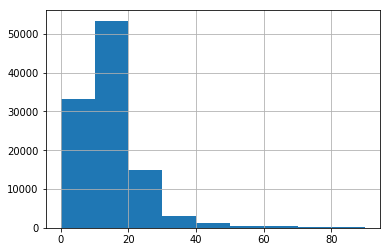

In [33]:
# Plot data as bins to see normality. slight skewness is still acceptable if feature is not very critical
df['incidtime'].astype('timedelta64[m]').hist(bins = range(0,100,10))

In [34]:
#pd.DataFrame(df['incidtime']).apply(np.float64)

### Incident Type

In [35]:
df['incidenttype_rm'].value_counts()

321 EMS call, excluding vehicle accident with inju    43831
300 Rescue, EMS incident, other                       12160
611 Dispatched & canceled en route                     8748
311 Medical assist, assist EMS crew                    6479
311 Medical assist, EMS crew                           4532
353 Removal of victim(s) from stalled elevator         3630
745 Alarm system activation,no fire,unintentional      3237
743 Smoke detector activation, no fire - unintenti     2316
600 Good intent call, other                            1906
622  No incident found on arrival at dispatch addr     1772
740 Unintentional transmission of alarm, other         1747
322 Motor vehicle accident with injuries               1514
324 Motor vehicle accident with no injuries            1430
733 Smoke detector activation due to malfunction       1137
735 Alarm system sounded due to malfunction             926
744 Detector activation, no fire - unintentional        894
500 Service Call, other                 

Combining incidents by their code value to minimize the different classes of incidents. Also combining some of the other incident codes to add up some rows for code 100 to adjust class imbalance.

In [36]:
df['inccode'] = np.where(df['inccode'].gt(100) & df['inccode'].lt(200), 100, df['inccode'])
df['inccode'] = np.where(df['inccode'].gt(200) & df['inccode'].lt(300), 200, df['inccode'])
df['inccode'] = np.where(df['inccode'].gt(400) & df['inccode'].lt(500), 400, df['inccode'])
df['inccode'] = np.where(df['inccode'].gt(500) & df['inccode'].lt(600), 500, df['inccode'])
df['inccode'] = np.where(df['inccode'].gt(600) & df['inccode'].lt(700), 600, df['inccode'])
df['inccode'] = np.where(df['inccode'].gt(700) & df['inccode'].lt(800), 700, df['inccode'])
df['inccode'] = np.where(df['inccode'].isin([311,353,322,324,331,323,354,351,350,352,341,357]), 100, df['inccode'])
df['inccode'] = np.where(df['inccode'].isin([800,815,911,900,200,400,500]), 100, df['inccode'])

In [37]:
df['inccode'].value_counts()

321.0    43831
100.0    25603
700.0    13748
600.0    12761
300.0    12169
Name: inccode, dtype: int64

Assigning names to incident codes to classify them into 5 broad categories

In [38]:
df['incidenttype_rm'] = np.where(df['inccode'].isin([100]), '100 Fire', df['incidenttype_rm'])
df['incidenttype_rm'] = np.where(df['inccode'].isin([321]), '321 EMSCall', df['incidenttype_rm'])
df['incidenttype_rm'] = np.where(df['inccode'].isin([700]), '700 Sprinkler_Alarm_Issues', df['incidenttype_rm'])
df['incidenttype_rm'] = np.where(df['inccode'].isin([600]), '600 Miscellaneous', df['incidenttype_rm'])
df['incidenttype_rm'] = np.where(df['inccode'].isin([300]), '300 EMS Rescue_Other', df['incidenttype_rm'])

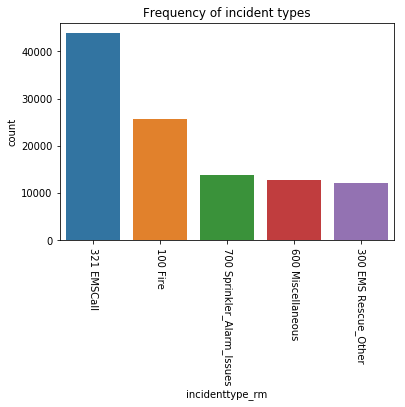

In [39]:
# Frequency of incident types
axs = sns.countplot(x='incidenttype_rm',data=df)
axs.set_title("Frequency of incident types")
# Rotate x-labels
plt.xticks(rotation=-90)
plt.show()

In [40]:
df['heatfuel_desc'].value_counts()

GAS            62208
ELECTRIC       17902
NONE           14113
OIL/WD/COAL    13889
Name: heatfuel_desc, dtype: int64

Municipali - has only one value, date fields like dateofsale, sprinklertestdate,firealarmtestdate (dont add value to the model),
shift is not needed, heatfuel_desc is repeated, inccode and incidenttype have been merged together as incident_type for further modeling.

In [41]:
# drop fields
df.drop([
    'municipali',
    'dateofsale',
    'unit',
    'propertyus',
    'descproper',    
    'shift',
    'builtdate',
    'sprinklertestdate',
    'firealarmtestdate',
    'codestatus',
    'heatfuel_desc',
    'inccode',
    'incidenttype'
],axis = 1, inplace = True)

### PropertyUse Description 

In [42]:
df.propertyuse_desc.value_counts()

Office                       34350
Commercial                   13942
Hotel/Motel                  13633
Govt-Inst                    13513
Warehouse Lg                  5171
COMMERCIAL                    5095
Warehouse                     4927
Multi-Family                  4631
Attached Res                  4161
MEDICAL BUILDING              3053
OFFICE                        2333
HOTEL/MOTEL HIGH RISE         1260
OFFICE HIGH RISE              1216
CONDO                          552
StadiumArena                    80
LIGHT MANUFACTURING             26
OTHER MUNICIPAL                 26
SERVICE STATION                 18
RESTAURANTS                     17
INDUSTRIAL                      13
BANKS                           12
SHOPPING CENTER-STRIP           12
GARDEN APARTMENT                 9
MORTUARY-CEMETERY                7
PARK SHELTER                     6
PREFAB WAREHOUSE                 6
FAST FOODS                       5
LOUNGE/NIGHTCLUB                 5
WAREHOUSE           

In [43]:
df = df[~df['propertyuse_desc'].isin(['CONSTRUCTION TRAILER','SEASONAL SALES','THEATER','GREENWAY ENTRANCE',
'CELL TOWER','METER'])]

In [44]:
# Check and combine multiple property uses into common bins as these many cannot be forced into the model

cleanup_nums = {"propertyuse_desc":     {"Warehouse Lg": "Warehouse",
                                         "SERVICE STATION": "Warehouse",
                                         "PREFAB WAREHOUSE" : "Warehouse",
                                         "WAREHOUSE" : "Warehouse",
                                         "UTILITY" : "Warehouse",
                                         "AUTO SALES/SERVICE" : "Warehouse",
                                         "COMMERCIAL" : "Commercial",
                                         "Multi-Family" : "Residential",
                                         "Attached Res" : "Residential",
                                         "GARDEN APARTMENT":"Residential",
                                         "Single-Fam" : "Residential",
                                         "HIGH-RISE APARTMENT" : "Residential",
                                         "SINGLE FAMILY RESORT" : "Residential",
                                         "SINGLE FAMILY RESIDENTIAL":"Residential",
                                         "OFFICE" : "Office", "HOTEL/MOTEL HIGH RISE" : "Hotel/Motel",
                                         "OFFICE HIGH RISE":"Office",
                                         "MEDICAL BUILDING" : "Govt-Inst",
                                         "StadiumArena" : "Govt-Inst",
                                         "OTHER MUNICIPAL":"Govt-Inst", "PUBLIC COLLEGE" : "Govt-Inst",
                                         "CONVENIENCE STORE": "Commercial",
                                         "SHOPPING CENTER-MALL": "Commercial",
                                         "MORTUARY-CEMETERY" : "Govt-Inst",
                                         "SHOPPING CENTER-STRIP" : "Commercial",
                                         "BANKS" : "Office",
                                         "LIGHT MANUFACTURING" : "Commercial",
                                         "INDUSTRIAL" : "Commercial",
                                         "COMMERCIAL/SERVICE" : "Commercial",
                                         "CONDO" : "Residential",
                                         "RESTAURANTS" : "Hotel/Motel",
                                         "FAST FOODS":"Hotel/Motel",
                                         "LOUNGE/NIGHTCLUB" : "Hotel/Motel",
                                         "CLUB-LODGE":"Hotel/Motel",
                                         "PARK SHELTER":"Residential"                       
                                        }}
df.replace(cleanup_nums, inplace=True)

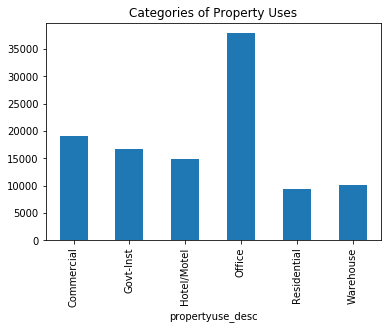

In [45]:
# Histogram of property use description
df.groupby('propertyuse_desc')['propertyuse_desc'].count().plot(kind='bar',title ='Categories of Property Uses')

### Heating Type 

In [46]:
df.aheatingty.value_counts()

AIR-DUCTED      55723
AC-PCKD ROOF    23625
HEAT - NONE     19593
HOT WATER        6086
HEAT PUMP        1473
AIR-NO-DUCT      1254
AC-CHLD WAT       250
AC-CENTRAL         65
BASEBOARD          32
Name: aheatingty, dtype: int64

In [47]:
cleanup_nums = {"aheatingty":     {"AIR-NO-DUCT": "HEAT MISC",
                                   "AC-CHLD WAT": "HEAT MISC",
                                   "AC-CENTRAL" : "HEAT MISC",
                                   "BASEBOARD"  : "HEAT MISC",
                                   "HEAT PUMP"  : "HEAT MISC",
                                   "HOT WATER"  : "HEAT MISC",
                                   "HEAT - NONE": "HEAT MISC"}}
df.replace(cleanup_nums, inplace=True)

#### Any of the frequency plots like the below are to understand the data distribution visually and determine if further categorization is needed or if any categories have to be combined for ease of modeling.

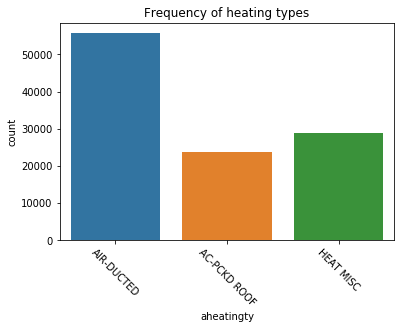

In [48]:
# Frequency of heating type
axs = sns.countplot(x='aheatingty',data=df)
axs.set_title("Frequency of heating types")
# Rotate x-labels
plt.xticks(rotation=-45)
plt.show()

### Heated Fuel

In [49]:
df.heatedfuel.value_counts()

GAS            55193
NONE           19568
OIL/WD/COAL    18835
ELECTRIC       14505
Name: heatedfuel, dtype: int64

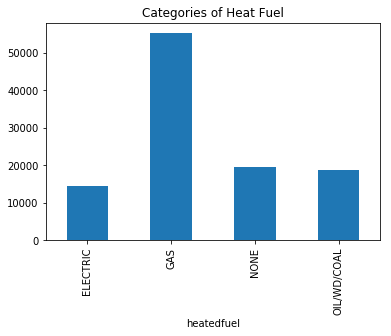

In [50]:
# Histogram of Heat Fuel
# Although Gas is the predominant heat fuel type, others are retained for understanding the usage in model

df.groupby('heatedfuel')['heatedfuel'].count().plot(kind='bar',title ='Categories of Heat Fuel')

### Building Grade Description

In [51]:
df.bldggrade_desc.value_counts()

CUSTOM 03       20716
EXCELLENT 03    18458
GOOD 03         16251
AVERAGE 03      11572
VERY GOOD 05     9898
VERY GOOD 03     9773
VERY GOOD 06     6091
EXCELLENT 01     2864
AVERAGE 05       2076
GOOD 02          2033
GOOD 01          1801
GOOD 06          1318
VERY GOOD 02     1209
GOOD 04           751
VERY GOOD 01      513
AVERAGE 01        467
EXCELLENT 06      437
AVERAGE 04        404
CUSTOM 04         288
AVERAGE 06        276
VERY GOOD 04      268
AVERAGE 02        267
GOOD 05           145
BELOW AVG 06      105
BELOW AVG 03       64
CUSTOM 02          24
EXCELLENT 02       13
BELOW AVG 01        7
BELOW AVG 02        6
CUSTOM 06           3
EXCELLENT 04        2
EXCELLENT 05        1
Name: bldggrade_desc, dtype: int64

Building Grades are combined into 6 broad categories - EXCELLENT, VERY GOOD, GOOD, AVERAGE, BELOW AVG and CUSTOM

In [52]:
cleanup_nums = {"bldggrade_desc":     {"EXCELLENT 01": "EXCELLENT", "EXCELLENT 02": "EXCELLENT",
                               "EXCELLENT 03": "EXCELLENT","EXCELLENT 04": "EXCELLENT",
                              "EXCELLENT 05": "EXCELLENT","EXCELLENT 06": "EXCELLENT",
                               "VERY GOOD 01" : "VERY GOOD","VERY GOOD 02" : "VERY GOOD",
                               "VERY GOOD 03" : "VERY GOOD","VERY GOOD 04" : "VERY GOOD",
                               "VERY GOOD 05" : "VERY GOOD","VERY GOOD 06" : "VERY GOOD",
                               "GOOD 01" : "GOOD","GOOD 02" : "GOOD",
                               "GOOD 03" : "GOOD","GOOD 04" : "GOOD",
                               "GOOD 05" : "GOOD","GOOD 06" : "GOOD",
                               "AVERAGE 01" : "AVERAGE","AVERAGE 02" : "AVERAGE",
                               "AVERAGE 03" : "AVERAGE","AVERAGE 04" : "AVERAGE",
                               "AVERAGE 05" : "AVERAGE","AVERAGE 06" : "AVERAGE",
                               "BELOW AVG 01" : "AVERAGE" ,"BELOW AVG 02" : "AVERAGE" ,
                               "BELOW AVG 03" : "AVERAGE" ,"BELOW AVG 04" : "AVERAGE" ,
                               "BELOW AVG 05" : "AVERAGE" ,"BELOW AVG 06" : "AVERAGE" ,                            
                               "CUSTOM 01" : "CUSTOM" ,"CUSTOM 02" : "CUSTOM" ,
                               "CUSTOM 03" : "CUSTOM" ,"CUSTOM 04" : "CUSTOM" ,
                               "CUSTOM 05" : "CUSTOM" ,"CUSTOM 06" : "CUSTOM"     
                               }}
df.replace(cleanup_nums, inplace=True)

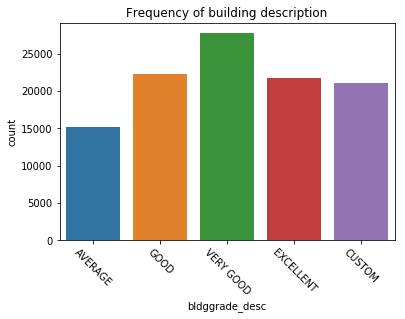

In [53]:
# Frequency of building description
axs = sns.countplot(x='bldggrade_desc',data=df)
axs.set_title("Frequency of building description")
# Rotate x-labels
plt.xticks(rotation=-45)
plt.show()

### Story Height

In [54]:
df.storyheight.value_counts()

1 STORY        46417
>= 2.5 STY     41446
2.0 STORY      19844
1.5 STORY        257
SPLIT LEVEL      137
Name: storyheight, dtype: int64

In [55]:
# Split levels and 1.5 Story are combined as 2.0 STORY as they were less in number and had to be grouped for modeling
cleanup_nums = {"storyheight":  {"1.5 STORY": "2.0 STORY", "SPLIT LEVEL":"2.0 STORY" }}
df.replace(cleanup_nums, inplace=True)

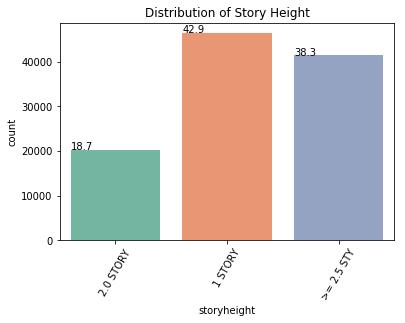

In [56]:
import seaborn as sns
ax = sns.countplot(x="storyheight", data=df, palette="Set2")
total = float(len(df.index))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+18, '%2.1f'%(height*100/total))
plt.xticks(rotation=60)
plt.title('Distribution of Story Height')
plt.show()

### Foundation Description

In [57]:
df.foundation_desc.value_counts()

HIGH RISE       37423
SLAB-COM        27284
SLAB-RES        17980
CRAWL SPACE     14282
SLAB-HEAVY       4987
SLAB-ABV GRD     4748
SLAB-STRUCT      1095
SLAB-PLFM HT      254
PIER               48
Name: foundation_desc, dtype: int64

In [58]:
# Combining various foundation descriptions of lesser count to manageable bins
cleanup_nums = {"foundation_desc":  {"CRAWL SPACE": "SLAB-OTHERS", "SLAB-PLFM HT":"SLAB-OTHERS",
                                    "PIER": "SLAB-OTHERS", "SLAB-HEAVY":"SLAB-OTHERS",
                                     "SLAB-STRUCT": "SLAB-OTHERS",
                                    "SLAB-ABV GRD": "SLAB-OTHERS"}}
df.replace(cleanup_nums, inplace=True)

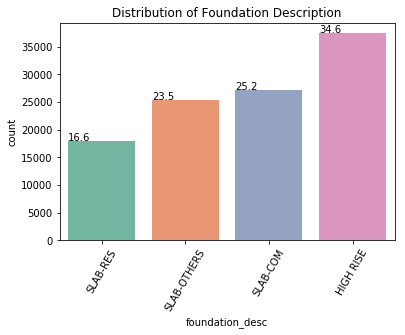

In [59]:
import seaborn as sns
ax = sns.countplot(x="foundation_desc", data=df, palette="Set2")
total = float(len(df.index))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+18, '%2.1f'%(height*100/total))
plt.xticks(rotation=60)
plt.title('Distribution of Foundation Description')
plt.show()

### Exterior Wall

In [60]:
df.extwall.value_counts()

FACE BRICK      28762
PRECAST PANL    21409
UNKNOWN         13683
SDG MIN/NONE    12055
GLASS/THRML      6602
STONE            6484
CONC BLOCK       5608
WOOD ON SHTG     4626
STUCCO HRDCT     3003
CEM BR/SPL B     1842
JUMBO/COM BR     1225
HARDIPLANK        670
MODULAR MTL       390
RNFR CONC         294
PREFIN MTL        279
EXT PLYWOOD       249
STUCCO SYNTH      235
MASONITE          233
ALUM,VINYL        221
CEDAR,RDWD        118
CORR MTL LGT       48
CORR MTL HVY       47
SIDG NO SHTG        7
ASB SHNG/SDG        6
BOARD&BATTEN        3
WOOD SHINGLE        2
Name: extwall, dtype: int64

There are too many exterior wall types and since there were no common means to group all of them, have combined any type which has summation(shown in the previous cell) less than 6000 as category CONC/OTHERS.

In [61]:
dcopy = df.copy()
df1 = df.groupby(['extwall']).extwall.count().reset_index(name='count')
df1.drop(df1[df1['count'] >6000].index,inplace=True)
common=df.merge(df1,on=['extwall'])
print(common.head())

               incdate               incend       incidenttype_rm  inspectabl  \
0  2014-06-11 17:41:01  2014-06-11 17:52:41           321 EMSCall           1   
1  2013-01-10 07:15:54  2013-01-10 07:27:39  300 EMS Rescue_Other           0   
2  2013-01-10 07:15:54  2013-01-10 07:27:39  300 EMS Rescue_Other           1   
3  2013-01-10 07:15:54  2013-01-10 07:27:39  300 EMS Rescue_Other           1   
4  2013-01-10 07:15:54  2013-01-10 07:27:39  300 EMS Rescue_Other           0   

   alarm  lockbox              instime  fireload  sprinkleredbuilding  \
0      0        0  2018-01-23 00:00:00         1                    0   
1      0        0  2010-02-17 00:00:00         1                    0   
2      0        0  1800-01-01 00:00:00         2                    0   
3     10        0  2016-01-07 00:00:00         2                    0   
4      0        0  2014-01-03 00:00:00         2                    0   

   health704  ...       extwall  amt_netbldgvalue  grossarea  cnt_units  \

In [62]:
newdf= df[(~df.extwall.isin(common.extwall))]
common.extwall = "CONC/OTHERS"
print(newdf)
df = pd.concat([newdf,common])

                    incdate               incend             incidenttype_rm  \
2       2016-01-01 00:49:01  2016-01-01 00:56:40                 321 EMSCall   
5       2013-11-02 14:21:57  2013-11-02 14:35:45                 321 EMSCall   
6       2013-11-02 14:21:57  2013-11-02 14:35:45                 321 EMSCall   
7       2014-01-10 20:06:05  2014-01-10 20:13:21                    100 Fire   
8       2014-01-10 20:06:05  2014-01-10 20:13:21                    100 Fire   
9       2014-08-26 03:02:53  2014-08-26 12:38:51                    100 Fire   
10      2014-08-26 03:02:53  2014-08-26 12:38:51                    100 Fire   
23      2013-04-03 03:57:10  2013-04-03 04:31:39  700 Sprinkler_Alarm_Issues   
24      2013-07-21 22:34:56  2013-07-21 22:46:32  700 Sprinkler_Alarm_Issues   
25      2013-08-09 19:42:18  2013-08-09 20:09:09  700 Sprinkler_Alarm_Issues   
26      2013-12-24 01:33:56  2013-12-24 05:09:18  700 Sprinkler_Alarm_Issues   
27      2013-12-24 21:16:07  2013-12-24 

In [63]:
df.extwall.value_counts()

FACE BRICK      28762
PRECAST PANL    21409
CONC/OTHERS     19106
UNKNOWN         13683
SDG MIN/NONE    12055
GLASS/THRML      6602
STONE            6484
Name: extwall, dtype: int64

In [64]:
df.drop(['count',], axis = 1, inplace = True)

In [65]:
# Since GLASS/THRML and STONE are still lesser in number compared to main category of FACE BRICK, combining them as GLASS/STONE
cleanup_nums = {"extwall":  {"GLASS/THRML": "GLASS/STONE", "STONE":"GLASS/STONE"}}
df.replace(cleanup_nums, inplace=True)

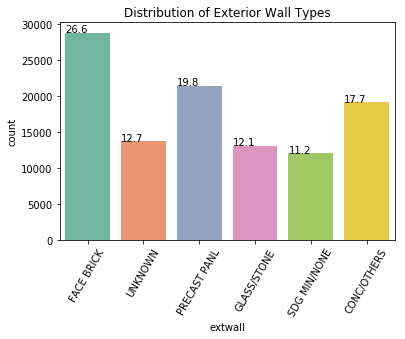

In [66]:
import seaborn as sns
ax = sns.countplot(x="extwall", data=df, palette="Set2")
total = float(len(df.index))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+18, '%2.1f'%(height*100/total))
plt.xticks(rotation=60)
plt.title('Distribution of Exterior Wall Types')
plt.show()

### Tax Spec Dis

In [67]:
df['taxspecdis'].value_counts()

DOWNTOWN DISTRICT 3    37231
UNKNOWN                30382
DOWNTOWN DISTRICT 2    27648
UNIVERSITY AREA         8298
DOWNTOWN DISTRICT 1     2365
DOWNTOWN DISTRICT 4     2164
FIRE SERVICE E            13
Name: taxspecdis, dtype: int64

In [68]:
cleanup_nums = {"taxspecdis":  {"UNIVERSITY AREA": "DOWNTOWN DISTRICT", "DOWNTOWN DISTRICT 1":"DOWNTOWN DISTRICT",
                               "DOWNTOWN DISTRICT 4":"DOWNTOWN DISTRICT","FIRE SERVICE E":"DOWNTOWN DISTRICT"}}
df.replace(cleanup_nums, inplace=True)

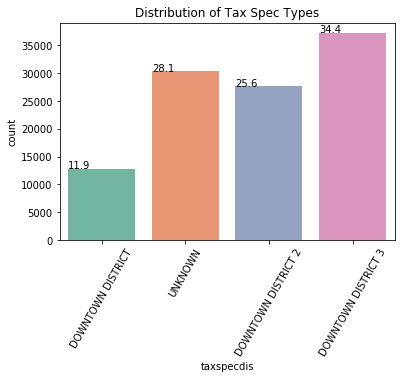

In [69]:
# Grouped plot of tax specification district
import seaborn as sns
ax = sns.countplot(x="taxspecdis", data=df, palette="Set2")
total = float(len(df.index))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x(), height+18, '%2.1f'%(height*100/total))
plt.xticks(rotation=60)
plt.title('Distribution of Tax Spec Types')
plt.show()

### Vacant or Improved

Using label encoder to transform vacant or improved land as 0 - Vacant , 1 - Improved

In [70]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
df["vacorimp"] = lb.fit_transform(df["vacantorim"])
df.drop(['vacantorim'],axis = 1, inplace = True)

In [71]:
df['vacorimp'].value_counts()

0    64369
1    43732
Name: vacorimp, dtype: int64

#### Ins Time - This is not used in the current model but can be included when the model is rerun with datetime values

df['instime'].value_counts()

df['instime'] = pd.to_datetime(df['instime'])

currentTime = datetime.now()
print(currentTime)

import time
fmt = '%Y-%m-%d'
df['insptime'] = pd.to_datetime(currentTime, format = fmt) - df['instime']

df['insptime']

### Building Age

Calculate age of building based on year built as Current Year - Year built. Creating this feature as older buildings might have more chances of catching fire or on similar assumptions. :)

In [72]:
from datetime import datetime
currentYear = datetime.now().year

In [73]:
df['building_age'] = currentYear - df['yearbuilt']

In [74]:
# Due to data issues, some dont have year built and those are considered as new buildings with age 1
df['building_age'] = df['building_age'].replace(2018,1)

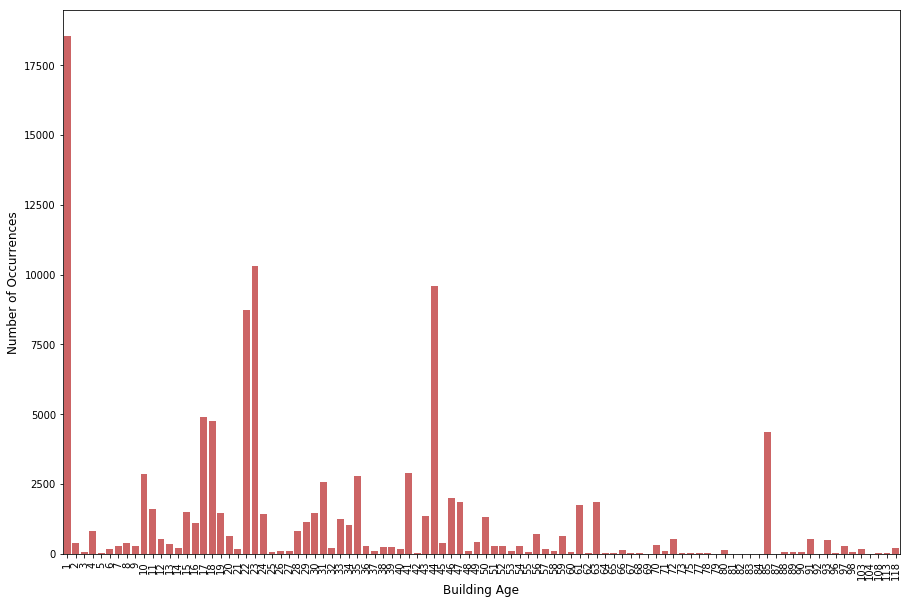

In [75]:
color = sns.color_palette()
cnt_srs = df['building_age'].value_counts()
plt.figure(figsize=(15,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Building Age', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

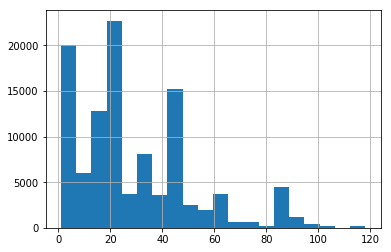

In [76]:
df['building_age'].hist(bins = 20)

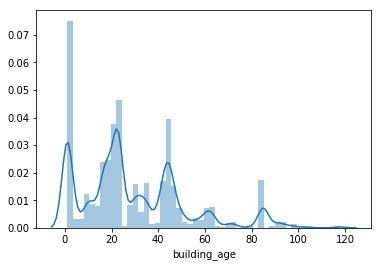

In [77]:
sns.distplot(df.building_age)
#df.building_age2 = np.log1p(df.building_age)
# Standardizing the attributes
#from sklearn.preprocessing import MinMaxScaler

#Scaler = MinMaxScaler()
#df['building_age3'] = Scaler.fit_transform(df[['building_age']])

Drop some more fields after initial preprocessing and transformation

In [78]:
df.drop(['codeuse','yearbuilt','incidtime','instime'],axis = 1, inplace = True)

### Assigned Frequency

In [79]:
df['assignedfrequency'].value_counts()

365     59609
1095    23873
0       22744
720      1149
182       452
1096       76
1097       75
366        33
1          33
20         31
730        12
1094        6
1085        3
1035        3
3365        2
Name: assignedfrequency, dtype: int64

In [80]:
# Combine assigned frequency values along with 720 as Others as the two main possible values are 365 and 1095
values = ([1035,3365,1085,730,1094,20,1,366,1096,1097,182,720,0])
df['assignedfrequency'] = np.where(df['assignedfrequency'].isin(values) , 'Others' ,df['assignedfrequency'])
df.replace({"assignedfrequency": {"365":"Yearly","1095":"Three Yearly"}}, inplace=True)

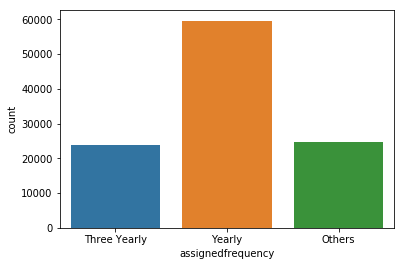

In [81]:
# Distribution Plot for assigned frequency
sns.countplot(df.assignedfrequency)

### Bedrooms

In [82]:
df['bedrooms'].value_counts()

0     93704
1     11955
2      2129
64      278
3        21
5        10
4         3
7         1
Name: bedrooms, dtype: int64

Bedrooms greater than one are less in number and hence combining together

In [83]:
values = ([7,4,5,3,64,2,1])
df['bedrooms'] = np.where(df['bedrooms'].isin(values) , 'One or more' ,df['bedrooms'])
df.replace({"bedrooms": {"0":"None"}}, inplace=True)

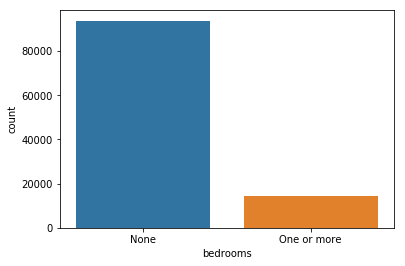

In [84]:
# Histogram of Bedrooms
sns.countplot(df.bedrooms)

### Alarm

In [85]:
df['alarm'].value_counts()

0     55860
4     31351
3      5743
6      5304
9      4035
10     2825
2      1065
7      1061
5       450
8       371
1        36
Name: alarm, dtype: int64

In [86]:
# More than 3 alarms can be grouped as Misc category
values = ([1,5,8,2,7,10,9,6,3])
df['alarm'] = np.where(df['alarm'].isin(values) , 'Misc' ,df['alarm'])
df.replace({"alarm": {"0":"No Alarm","4":"Four Alarms"}}, inplace=True)

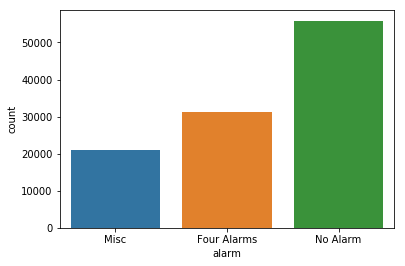

In [87]:
# Distribution Plot for alarms
sns.countplot(df.alarm)

### Cnt_Otherfixtures

In [88]:
df['cnt_otherfixtures'].value_counts()

99.000000      20040
192.297568     11504
0.000000       11329
79.000000      10055
15.000000       5994
50.000000       4358
824.000000      4275
1224.000000     2748
1293.000000     2595
1.000000        1692
874.000000      1692
25.000000       1636
6.000000        1561
16.000000       1516
282.000000      1443
4.000000        1442
92.000000       1434
38.000000       1421
10.000000       1151
12.000000       1142
8.000000        1138
104.000000      1008
40.000000        959
588.000000       884
34.000000        883
2.000000         844
32.000000        843
134.000000       721
30.000000        654
24.000000        611
               ...  
445.000000        30
438.000000        28
75.000000         25
490.000000        21
591.000000        20
833.000000        20
89.000000         18
678.000000        18
456.000000        17
227.000000        17
258.000000        16
108.000000        15
140.000000        11
44.000000         10
971.000000         9
144.000000         8
74.000000    

Since the count of other fixtures is widely varying, grouping them based on count into 4 main bins for ease in modeling

In [89]:
df['cnt_otherfixtures'] = np.where(df['cnt_otherfixtures'].gt(-1) & df['cnt_otherfixtures'].lt(51) , 50 ,df['cnt_otherfixtures'])
df['cnt_otherfixtures'] = np.where(df['cnt_otherfixtures'].gt(51) & df['cnt_otherfixtures'].lt(99) , 79 ,df['cnt_otherfixtures'])
df['cnt_otherfixtures'] = np.where(df['cnt_otherfixtures'].gt(100) & df['cnt_otherfixtures'].lt(5000) , 500 ,df['cnt_otherfixtures'])

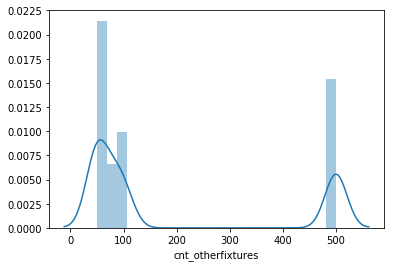

In [90]:
sns.distplot(df['cnt_otherfixtures'])

In [91]:
df['cnt_otherfixtures'].value_counts()

50.0     43415
500.0    31260
99.0     20040
79.0     13386
Name: cnt_otherfixtures, dtype: int64

### Nbr_Stories

In [92]:
df['nbrstories'].value_counts()

1     54553
0     30910
2      8123
3      3923
6      2381
5      1318
4      1264
8       824
10      683
12      497
27      459
7       447
19      395
13      377
11      342
20      234
41      225
22      162
33      159
51      150
16      140
35      112
14      108
15       78
31       74
17       51
37       51
40       32
25       28
9         1
Name: nbrstories, dtype: int64

In [93]:
# Apart from 0 and 1, other number of stories are minimal, combine all together
df['nbrstories'] = np.where(df['nbrstories'].gt(1) , 2 ,df['nbrstories'])

### Occupancy Load

In [94]:
df['occupancyload'].value_counts()

10      17421
1       13893
20       7673
50       6360
0        5995
300      4338
65       4187
9        3502
5        3448
15       3155
49       3028
2        2117
100      2103
30       2062
2000     2054
200      1907
40       1592
25       1355
5000     1099
1500      958
99        863
45        821
4         813
60        742
500       741
1200      651
400       601
150       572
35        526
3         500
        ...  
2800        5
720         5
119         5
632         4
110         4
148         3
257         3
62          3
38          3
138         3
51          3
235         3
133         3
538         3
360         2
1162        2
550         2
337         2
225         2
101         2
103         2
58          1
108         1
345         1
172         1
294         1
317         1
102         1
109         1
170         1
Name: occupancyload, Length: 235, dtype: int64

In [95]:
# Since the occupancy load feature is widely varying, grouping based on count into 4 main bins for ease in modeling
df['occupancyload'] = np.where(df['occupancyload'].gt(500) , 500 ,df['occupancyload'])
df['occupancyload'] = np.where(df['occupancyload'].gt(200) , 200 ,df['occupancyload'])
df['occupancyload'] = np.where(df['occupancyload'].gt(-1) & df['occupancyload'].lt(10) , 5 ,df['occupancyload'])
df['occupancyload'] = np.where(df['occupancyload'].gt(21) & df['occupancyload'].lt(49) , 21 ,df['occupancyload'])
df['occupancyload'] = np.where(df['occupancyload'].gt(49) & df['occupancyload'].lt(200) , 130 ,df['occupancyload'])
values = ([17,18,19,11,13,14,16,12,49,15,20,21])
df['occupancyload'] = np.where(df['occupancyload'].isin(values), 20 ,df['occupancyload'])

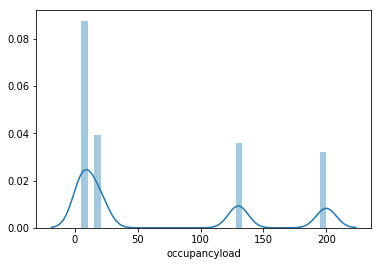

In [96]:
# Distribution plot for occupancy load
sns.distplot(df.occupancyload)

Assigned Fequency, Alarm and Bedrooms are converted to object types for categorical modeling

In [97]:
df['assignedfrequency'].astype('object')
df['alarm'].astype('object')
df['bedrooms'].astype('object')

2        None
5        None
6        None
7        None
8        None
9        None
10       None
23       None
24       None
25       None
26       None
27       None
31       None
32       None
33       None
34       None
35       None
36       None
37       None
38       None
50       None
51       None
52       None
53       None
54       None
276      None
277      None
282      None
283      None
284      None
         ... 
19076    None
19077    None
19078    None
19079    None
19080    None
19081    None
19082    None
19083    None
19084    None
19085    None
19086    None
19087    None
19088    None
19089    None
19090    None
19091    None
19092    None
19093    None
19094    None
19095    None
19096    None
19097    None
19098    None
19099    None
19100    None
19101    None
19102    None
19103    None
19104    None
19105    None
Name: bedrooms, Length: 108101, dtype: object

### Fire Load

In [98]:
df['fireload'].value_counts()

2    51997
0    42880
1    11470
3     1641
4      113
Name: fireload, dtype: int64

In [99]:
values = ([1,3,4])
df['fireload'] = np.where(df['fireload'].isin(values) , 1 ,df['fireload'])

df.replace({"fireload":{0:"Zero",1:"One",2:"Two"}}, inplace=True)

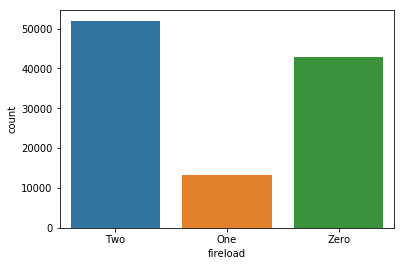

In [100]:
df['fireload'] = df.fireload.astype(object)
sns.countplot(df['fireload'])

### Units

In [101]:
df['units'].value_counts() 

1      53849
0      37523
700     4275
374     2748
438     2595
170      884
4        770
42       721
8        462
336      350
154      327
175      325
181      324
150      308
90       278
274      255
82       248
60       247
104      192
76       172
141      148
10       118
80        99
54        85
40        66
22        61
45        60
5         57
24        53
72        46
18        45
32        42
120       36
192       31
142       30
133       29
145       28
13        28
6         28
12        27
86        21
100       21
197       20
163       18
152       17
16         9
237        9
7          6
30         4
15         2
2          2
62         2
Name: units, dtype: int64

Units greater than one are marked as 2, and overall becomes 3 categories of units

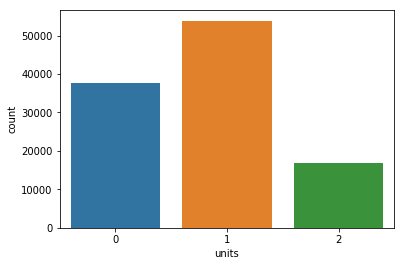

In [102]:
df['units'] = np.where(df['units'].gt(1), 2 ,df['units'])

# Plot the number of units as histogram
sns.countplot(df['units'])

### Assign Fire Values

#### Any row with incident type as "100 Fire" is marked as 1 - for the newly created feature "Fire", Else it is marked as "0 - No Fire". This will be used as the decision variable in further modeling to identify if a building had previous fire history or not.

In [103]:
df['fire'] = np.where(df["incidenttype_rm"].str.contains("100 Fire"),1,0)

In [104]:
df['fire'].value_counts()

0    82499
1    25602
Name: fire, dtype: int64

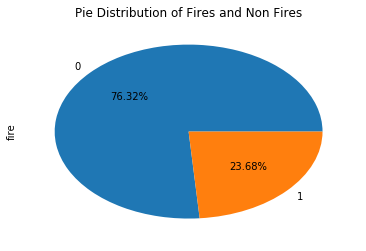

In [105]:
df.fire.value_counts().plot(x=None,y=None, kind='pie', autopct='%1.2f%%')
plt.title("Pie Distribution of Fires and Non Fires")
plt.show()

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108101 entries, 2 to 19105
Data columns (total 61 columns):
aheatingty               108101 non-null object
alarm                    108101 non-null object
amt_netbldgvalue         108101 non-null float64
assignedfrequency        108101 non-null object
bedrooms                 108101 non-null object
bldggrade_desc           108101 non-null object
bldgheight               108101 non-null int64
bldglen                  108101 non-null int64
bldgwidth                108101 non-null int64
cnt_otherfixtures        108101 non-null float64
cnt_units                108101 non-null float64
extwall                  108101 non-null object
fire704                  108101 non-null int64
fireload                 108101 non-null object
firestation              108101 non-null int64
floorcrowedind           108101 non-null int64
floorhighpileind         108101 non-null int64
flooropenpitind          108101 non-null int64
floorunsafeind           108101

### Check Correlation

#### In regression, "multicollinearity" refers to predictors that are correlated with other predictors.  Multicollinearity occurs when the model includes multiple factors that are correlated not just to response variable, but also to each other. In other words, it results when the model has factors that are a bit redundant. Multicollinearity increases the standard errors of the coefficients. Increased standard errors in turn means that coefficients for some independent variables may be found not to be significantly different from 0. In other words, by overinflating the standard errors, multicollinearity makes some variables statistically insignificant when they should be significant.

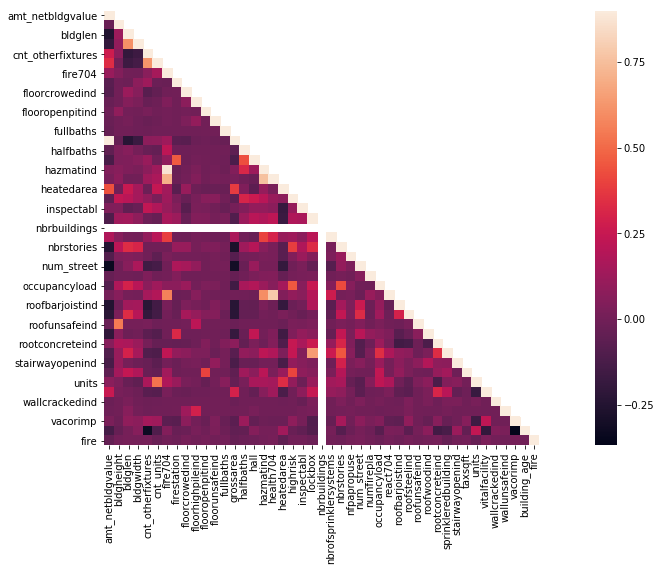

In [107]:
# Calculate correlations
corrMatt = df.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.heatmap(corrMatt, mask=mask,vmax=0.9, square=True)

The above heat map will indicate variables which are highly correlated with each other. The x and y axis contains features in the model and the bar on right corner denotes the collinearity value. As a general norm, anything about 0.70 is to be removed for better accuracy scores in the model. Based on this idea, some features which are redundant are removed from the model before further processing.

In [108]:
df.drop(['incidenttype_rm','bldgheight','bldglen','bldgwidth','firestation','hall','nfpapropuse','incend',
               'amt_netbldgvalue','heatedarea','cnt_units'],axis = 1, inplace = True)

### Get dummy values

Dummy coding allows to turn categories into something a regression can treat as having a high (1) and low (0) score. Any binary variable can be thought of as having directionality, because if it is higher, it is category 1, but if it is lower, it is category 0. This allows the regression look at directionality by comparing two sides, rather than expecting each unit to correspond with some kind of increase. 

In [109]:
dfdumm = pd.get_dummies(df, columns=["aheatingty","alarm","assignedfrequency","bedrooms","bldggrade_desc","fireload","foundation_desc",
                                     "heatedfuel","propertyuse_desc","storyheight","taxspecdis","extwall"],
                      prefix=["heat","alrm","freq","bedr","bldg","fload","foundn","heatfuel",
                              "propuse","storyh","taxdis","wall"])

In [110]:
dfdumm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108101 entries, 2 to 19105
Data columns (total 84 columns):
cnt_otherfixtures             108101 non-null float64
fire704                       108101 non-null int64
floorcrowedind                108101 non-null int64
floorhighpileind              108101 non-null int64
flooropenpitind               108101 non-null int64
floorunsafeind                108101 non-null int64
fullbaths                     108101 non-null int64
fullstreet                    108101 non-null object
grossarea                     108101 non-null float64
halfbaths                     108101 non-null int64
hazmatind                     108101 non-null int64
health704                     108101 non-null int64
highrisk                      108101 non-null int64
incdate                       108101 non-null object
inspectabl                    108101 non-null int64
lockbox                       108101 non-null int64
nbrbuildings                  108101 non-null int64


In [111]:
# Check for multicollinearity using correlation values
cor = dfdumm.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.70) | (cor < -0.70)]

hazmatind             fire704                 0.874110
health704             fire704                 0.706460
                      hazmatind               0.759875
react704              health704               0.784680
alrm_No Alarm         sprinkleredbuilding    -0.825670
freq_Others           inspectabl             -0.808450
bedr_One or more      bedr_None              -1.000000
bldg_CUSTOM           heat_AC-PCKD ROOF       0.755574
fload_Zero            fload_Two              -0.780595
foundn_HIGH RISE      grossarea               0.706186
heatfuel_NONE         heat_HEAT MISC          0.780993
                      foundn_SLAB-RES         0.825558
heatfuel_OIL/WD/COAL  heat_AC-PCKD ROOF       0.858687
storyh_>= 2.5 STY     foundn_HIGH RISE        0.812174
wall_UNKNOWN          heat_AC-PCKD ROOF       0.719853
                      bldg_CUSTOM             0.774582
                      heatfuel_OIL/WD/COAL    0.828750
                      storyh_2.0 STORY        0.793200
dtype: flo

The above code validates correlation between variables once again in the model and anything greater than 70% is dropped off from further processing.

In [112]:
dfdumm.drop(['grossarea','hazmatind','alrm_No Alarm','bedr_One or more','bedr_None',
       'heatfuel_OIL/WD/COAL','heatfuel_NONE','propuse_Hotel/Motel','react704','freq_Others',
        'bldg_CUSTOM','fload_Zero','foundn_HIGH RISE','storyh_2.0 STORY',
       'storyh_>= 2.5 STY','health704','fire704','wall_UNKNOWN'],
       axis = 1, inplace = True)

Plotting heat map once again to verify if the data looks good for final split up before modeling

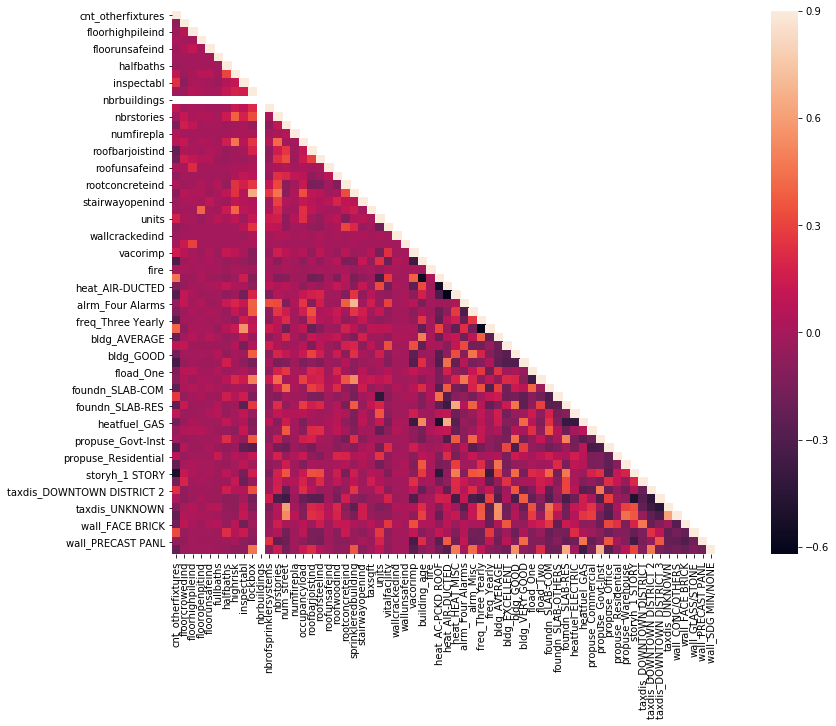

In [113]:
# Calculate correlations and plot heatmap
corrMatt = dfdumm.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=0.9, square=True)

#### The below 5 lines of code can be used if test / train split has to be done using arbitrary split and not based on time (months/years). A 75%, 25% split would allot 75% as training data and 25% as test data arbitrarily. However, it is important to verify balanced weight for target variable - Fire (0/1) in both training and test sets. Sometimes the splits yielded all non fire values in the test set which is not favorable to use in a model.

### Divide into training and test data

Since the predictor variable is less in number (about 25%), compared to other category, training and test split is being carried out based on time periods. A cut off date is chosen and any incident beyond that falls into test category and any incident which had occurred before that time period is a training category. Initially 12 months was chosen as cut off date and the class imbalance of No Fire data was too vast for the model to handle. And after multiple iterations of months, the number 36 was chosen for cut off date and the date was fixed as '2015-05-07'.

In [116]:
from dateutil.relativedelta import relativedelta
cutoff = datetime.now() - relativedelta(months=36)
cutoffdate = cutoff.strftime("%Y-%m-%d %H:%M:%S")

cutoffdate

#np.where((dfdumm["incdate"].str.contains("2018"))& (dfdumm['fire'] == 0))

'2015-05-07 22:36:02'

In [117]:
testdata = dfdumm[dfdumm['incdate'] > cutoffdate]

traindata = dfdumm[dfdumm['incdate'] <= cutoffdate]

In [118]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63901 entries, 5 to 19105
Data columns (total 66 columns):
cnt_otherfixtures             63901 non-null float64
floorcrowedind                63901 non-null int64
floorhighpileind              63901 non-null int64
flooropenpitind               63901 non-null int64
floorunsafeind                63901 non-null int64
fullbaths                     63901 non-null int64
fullstreet                    63901 non-null object
halfbaths                     63901 non-null int64
highrisk                      63901 non-null int64
incdate                       63901 non-null object
inspectabl                    63901 non-null int64
lockbox                       63901 non-null int64
nbrbuildings                  63901 non-null int64
nbrofsprinklersystems         63901 non-null int64
nbrstories                    63901 non-null int64
num_street                    63901 non-null int64
numfirepla                    63901 non-null int64
occupancyload       

Once the split is done, INCDATE is no longer useful for the model and hence can be removed from the dataframe of test and training set.

In [119]:
traindata.drop(['incdate'],axis = 1,inplace = True)
testdata.drop(['incdate'],axis = 1,inplace = True)

Divide the train and test data further to x and y variables, anything except Fire is in x_train or x_test

In [120]:
#converting to array and reshaping the data to prep for model
fireVarTrain =traindata['fire']
del traindata['fire']

x_train = traindata
y_train = fireVarTrain.values

#converting to array and reshaping the data to prep for model
fireVarTest = testdata['fire']
del testdata['fire']

x_test = testdata
y_test = fireVarTest.values

In [121]:
# Check the count of y_train or y_test to ensure there is a reasonable split of Fire and no Fire incidents
from collections import Counter
Counter(y_train)

Counter({0: 49000, 1: 14901})

In [122]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(63901, 64)
(63901,)
(44200, 64)
(44200,)


!! Check train data one last time to ensure there are no categorical values !!

In [123]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63901 entries, 5 to 19105
Data columns (total 64 columns):
cnt_otherfixtures             63901 non-null float64
floorcrowedind                63901 non-null int64
floorhighpileind              63901 non-null int64
flooropenpitind               63901 non-null int64
floorunsafeind                63901 non-null int64
fullbaths                     63901 non-null int64
fullstreet                    63901 non-null object
halfbaths                     63901 non-null int64
highrisk                      63901 non-null int64
inspectabl                    63901 non-null int64
lockbox                       63901 non-null int64
nbrbuildings                  63901 non-null int64
nbrofsprinklersystems         63901 non-null int64
nbrstories                    63901 non-null int64
num_street                    63901 non-null int64
numfirepla                    63901 non-null int64
occupancyload                 63901 non-null int64
roofbarjoistind      

#### Make a copy of train and test data for later use to append street number and name after fire risk prediction. For now, drop these two values and add them later in the model

In [124]:
x_train1 = x_train.copy()
y_train1 = y_train.copy()
x_test1 = x_test.copy()
y_test1 = y_test.copy()

In [125]:
x_train.drop(['num_street','fullstreet'],axis = 1,inplace = True)
x_test.drop(['num_street','fullstreet'],axis = 1,inplace = True)

### SMOTE sampling

SMOTE algorithm (Synthetic Minority Oversampling Technique) -  Used to handle imbalanced class distribution of Fire variable
At a high level, SMOTE creates synthetic observations of the minority class by:

   Finding the k-nearest-neighbors for minority class observations (finding similar observations)
   Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

After upsampling to a class ratio of 1.0, we should have a balanced dataset.

In [126]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
y_train = pd.DataFrame(y_train_res,columns=['fire'])
x_train = pd.DataFrame(x_train_res, columns=x_train.columns)

C:\Users\96926\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


### Naive Bayes

#### Naive Bayes classifier calculates the probabilities for every factor, then it selects the outcome with highest probability. This classifier assumes the features are independent, i.e, the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [127]:
# 10 fold cross validaton for GaussianNB

print ("Model: Gaussian Naive Bayes")
nb = GaussianNB() 

precision_nb = cross_val_score(nb, x_train, np.ravel(y_train), cv=5, scoring='precision')
print ("Precision = {}".format(precision_nb.mean()))
recall_nb = cross_val_score(nb, x_train, np.ravel(y_train), cv=5, scoring='recall')
print ("Recall    = {}".format(recall_nb.mean()))
f1score_nb = cross_val_score(nb, x_train, np.ravel(y_train), cv=5, scoring='f1')
print ("F1 Score  = {}".format(f1score_nb.mean()))
accuracy_nb = cross_val_score(nb, x_train, np.ravel(y_train), cv=5, scoring='accuracy')
print ("Accuracy  = {}".format(accuracy_nb.mean()))

Model: Gaussian Naive Bayes
Precision = 0.4640350014400843
Recall    = 0.606326530612245
F1 Score  = 0.48510055245006056
Accuracy  = 0.487734693877551


In [128]:
# Naive Bayes to fit training and test data

naiveb = GaussianNB()

#naiveb.fit(x_train, y_train)
naiveb.partial_fit(x_train,y_train,np.unique(y_train))

nb_pred = naiveb.predict(x_test)

print (metrics.confusion_matrix(y_test, nb_pred))
print (metrics.classification_report(y_test, nb_pred))
print(metrics.accuracy_score(y_test, nb_pred, normalize = True))

print("Training score is ",naiveb.score(x_train, y_train))
print("Testing score is ",naiveb.score(x_test, y_test))

[[ 6667 26832]
 [ 1957  8744]]
             precision    recall  f1-score   support

          0       0.77      0.20      0.32     33499
          1       0.25      0.82      0.38     10701

avg / total       0.65      0.35      0.33     44200

0.348665158371
Training score is  0.517795918367
Testing score is  0.348665158371


### Logistic Regression

#### Logistic regression is a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes). In logistic regression, the dependent variable is binary or dichotomous. 

In [129]:
# 10 fold cross validaton for Logistic Regression

print ("Model: Logistic Regression")
lr = LogisticRegression(class_weight = 'balanced')

precision_lr = cross_val_score(lr, x_train, y_train, cv=10, scoring='precision', n_jobs=-1)
print ("Precision = {}".format(precision_lr.mean()))
recall_lr = cross_val_score(lr, x_train, y_train, cv=10, scoring='recall', n_jobs=-1)
print ("Recall    = {}".format(recall_lr.mean()))
f1score_lr = cross_val_score(lr, x_train, y_train, cv=10, scoring='f1', n_jobs=-1)
print ("F1 Score  = {}".format(f1score_lr.mean()))
accuracy_lr = cross_val_score(lr, x_train,y_train, cv=10, scoring='accuracy', n_jobs=-1)
print ("Accuracy  = {}".format(accuracy_lr.mean()))

Model: Logistic Regression
Precision = 0.4599644220996947
Recall    = 0.5593673469387755
F1 Score  = 0.5010089590446354
Accuracy  = 0.4333775510204082


In [130]:
# Logistic Regression to fit training and test data

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(x_train, y_train)

lr_pred = logreg.predict(x_test)

print (metrics.confusion_matrix(y_test, lr_pred))
print (metrics.classification_report(y_test, lr_pred))
print(metrics.accuracy_score(y_test, lr_pred, normalize = False))

print("Training score is ",logreg.score(x_train, y_train))
print("Testing score is ",logreg.score(x_test, y_test))

[[19337 14162]
 [ 5637  5064]]
             precision    recall  f1-score   support

          0       0.77      0.58      0.66     33499
          1       0.26      0.47      0.34     10701

avg / total       0.65      0.55      0.58     44200

24401
Training score is  0.587744897959
Testing score is  0.552058823529


### Decision Trees

#### Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). It is one of the predictive modelling approaches used in statistics, data mining and machine learning.

In [131]:
# 10 fold cross validaton for Decision Trees

print ("Model: Decision Trees")
dt = DecisionTreeClassifier(criterion='entropy',class_weight = 'balanced')

precision_dt = cross_val_score(dt, x_train, np.ravel(y_train), cv=10, scoring='precision', n_jobs=-1)
print ("Precision = {}".format(precision_dt.mean()))
recall_dt = cross_val_score(dt, x_train, np.ravel(y_train), cv=10, scoring='recall', n_jobs=-1)
print ("Recall    = {}".format(recall_dt.mean()))
f1score_dt = cross_val_score(dt, x_train, np.ravel(y_train), cv=10, scoring='f1', n_jobs=-1)
print ("F1 Score  = {}".format(f1score_dt.mean()))
accuracy_dt = cross_val_score(dt, x_train, np.ravel(y_train), cv=10, scoring='accuracy', n_jobs=-1)
print ("Accuracy  = {}".format(accuracy_dt.mean()))

Model: Decision Trees
Precision = 0.4670490048382468
Recall    = 0.5933061224489796
F1 Score  = 0.5199832953235325
Accuracy  = 0.4435102040816326


In [132]:
# Decision Tree to fit training and test data

infoGain_clf = DecisionTreeClassifier(criterion='entropy',class_weight = 'balanced')

infoGain_clf.fit(x_train, y_train)

dt_pred = infoGain_clf.predict(x_test)

print (metrics.confusion_matrix(y_test, dt_pred))
print (metrics.classification_report(y_test, dt_pred))

print (metrics.accuracy_score(y_test, dt_pred,normalize=False))

print("Training score is ",infoGain_clf.score(x_train, y_train))
print("Testing score is ",infoGain_clf.score(x_test, y_test))


[[17370 16129]
 [ 4534  6167]]
             precision    recall  f1-score   support

          0       0.79      0.52      0.63     33499
          1       0.28      0.58      0.37     10701

avg / total       0.67      0.53      0.57     44200

23537
Training score is  0.649163265306
Testing score is  0.532511312217


In [133]:
data_features_names = list(x_train.columns.values)
print(data_features_names)

['cnt_otherfixtures', 'floorcrowedind', 'floorhighpileind', 'flooropenpitind', 'floorunsafeind', 'fullbaths', 'halfbaths', 'highrisk', 'inspectabl', 'lockbox', 'nbrbuildings', 'nbrofsprinklersystems', 'nbrstories', 'numfirepla', 'occupancyload', 'roofbarjoistind', 'roofsteelind', 'roofunsafeind', 'roofwoodind', 'rootconcreteind', 'sprinkleredbuilding', 'stairwayopenind', 'taxsqft', 'units', 'vitalfacility', 'wallcrackedind', 'wallunsafeind', 'vacorimp', 'building_age', 'heat_AC-PCKD ROOF', 'heat_AIR-DUCTED', 'heat_HEAT MISC', 'alrm_Four Alarms', 'alrm_Misc', 'freq_Three Yearly', 'freq_Yearly', 'bldg_AVERAGE', 'bldg_EXCELLENT', 'bldg_GOOD', 'bldg_VERY GOOD', 'fload_One', 'fload_Two', 'foundn_SLAB-COM', 'foundn_SLAB-OTHERS', 'foundn_SLAB-RES', 'heatfuel_ELECTRIC', 'heatfuel_GAS', 'propuse_Commercial', 'propuse_Govt-Inst', 'propuse_Office', 'propuse_Residential', 'propuse_Warehouse', 'storyh_1 STORY', 'taxdis_DOWNTOWN DISTRICT', 'taxdis_DOWNTOWN DISTRICT 2', 'taxdis_DOWNTOWN DISTRICT 3', 

### Random Forest

#### Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object. This works well because a single decision tree may be prone to a noise, but aggregate of many decision trees reduce the effect of noise giving more accurate results.

In [134]:
# 10 fold cross validaton for Random Forest

print ("Model: Random Forest")
rf = RandomForestClassifier(n_estimators=10, min_samples_split=2,class_weight = 'balanced')

precision_rf = cross_val_score(rf, x_train, np.ravel(y_train), cv=10, scoring='precision', n_jobs=-1)
print ("Precision = {}".format(precision_rf.mean()))
recall_rf = cross_val_score(rf, x_train, np.ravel(y_train), cv=10, scoring='recall', n_jobs=-1)
print ("Recall    = {}".format(recall_rf.mean()))
f1score_rf = cross_val_score(rf, x_train, np.ravel(y_train), cv=10, scoring='f1', n_jobs=-1)
print ("F1 Score  = {}".format(f1score_rf.mean()))
accuracy_rf = cross_val_score(rf, x_train, np.ravel(y_train), cv=10, scoring='accuracy', n_jobs=-1)
print ("Accuracy  = {}".format(accuracy_rf.mean()))

Model: Random Forest
Precision = 0.4627772824953075
Recall    = 0.601
F1 Score  = 0.5248111150561143
Accuracy  = 0.4366020408163265


In [135]:
# Random Forest to fit training and test data

randomf = RandomForestClassifier(n_estimators=10, min_samples_split=2,class_weight = 'balanced')

randomf.fit(x_train, y_train)

rf_pred = randomf.predict(x_test)

print (metrics.confusion_matrix(y_test, rf_pred))
print (metrics.classification_report(y_test, rf_pred))

print("Training score is ",randomf.score(x_train, y_train))
print("Testing score is ",randomf.score(x_test, y_test))

[[19189 14310]
 [ 5354  5347]]
             precision    recall  f1-score   support

          0       0.78      0.57      0.66     33499
          1       0.27      0.50      0.35     10701

avg / total       0.66      0.56      0.59     44200

Training score is  0.648520408163
Testing score is  0.555113122172


### KNN Classifier

#### KNN is a non-parametric, lazy learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point. KNN can be used for classification — the output is a class membership (predicts a class — a discrete value). An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. 

In [136]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_resc = scaler.fit_transform(x_train)

In [137]:
# 10 fold cross validaton for KNN Classifier

print ("Model: K Nearest Neighbor")
nn = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')

precision_nn = cross_val_score(nn, x_train_resc, np.ravel(y_train), cv=10, scoring='precision', n_jobs=-1)
print ("Precision = {}".format(precision_nn.mean()))
recall_nn = cross_val_score(nn, x_train_resc, np.ravel(y_train), cv=10, scoring='recall', n_jobs=-1)
print ("Recall    = {}".format(recall_nn.mean()))
f1score_nn = cross_val_score(nn, x_train_resc, np.ravel(y_train), cv=10, scoring='f1', n_jobs=-1)
print ("F1 Score  = {}".format(f1score_nn.mean()))
accuracy_nn = cross_val_score(nn, x_train_resc, np.ravel(y_train), cv=10, scoring='accuracy', n_jobs=-1)
print ("Accuracy  = {}".format(accuracy_nn.mean()))

Model: K Nearest Neighbor
Precision = 0.4599568251438303
Recall    = 0.5746938775510204
F1 Score  = 0.5071626175914614
Accuracy  = 0.4351836734693878


In [138]:
# KNN to fit training and test data

knnclass = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')

knnclass.fit(x_train_resc, y_train)

kn_pred = knnclass.predict(x_test)

print (metrics.confusion_matrix(y_test, kn_pred))
print (metrics.classification_report(y_test, kn_pred))

print("Training score is ",knnclass.score(x_train_resc, y_train))
print("Testing score is ",knnclass.score(x_test, y_test))

[[21872 11627]
 [ 6883  3818]]
             precision    recall  f1-score   support

          0       0.76      0.65      0.70     33499
          1       0.25      0.36      0.29     10701

avg / total       0.64      0.58      0.60     44200

Training score is  0.585642857143
Testing score is  0.581221719457


### K Best Features

In [139]:
from sklearn.feature_selection import SelectKBest
kbest = SelectKBest(k=10)
xtrain = kbest.fit_transform(x_train,np.ravel(y_train))

mask = kbest.get_support()
new_features = x_train.columns[mask]

In [140]:
print(new_features)

Index(['units', 'heat_AC-PCKD ROOF', 'propuse_Commercial', 'propuse_Govt-Inst',
       'propuse_Residential', 'taxdis_DOWNTOWN DISTRICT 2', 'wall_FACE BRICK',
       'wall_GLASS/STONE', 'wall_PRECAST PANL', 'wall_SDG MIN/NONE'],
      dtype='object')


### AdaBoost Classifier

#### Ada-boost, like Random Forest Classifier is another ensemble classifier. (Ensemble classifier are made up of multiple classifier algorithms and whose output is combined result of output of those classifier algorithms). Ada Boost retrains the algorithm iteratively by choosing the training set based on accuracy of previous training. The weight-age of each trained classifier at any iteration depends on the accuracy achieved.

In [141]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import cohen_kappa_score

model_adaboost = AdaBoostClassifier(n_estimators = 70, random_state=432, algorithm='SAMME.R')
print(model_adaboost)
model_adaboost.fit(x_train, y_train)
pred_adaboost = model_adaboost.predict(x_test)
real_adaboost = y_test
cm_ada = confusion_matrix(real_adaboost, pred_adaboost)
print(cm_ada)

kappa_ada = cohen_kappa_score(real_adaboost, pred_adaboost)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=70, random_state=432)
[[19669 13830]
 [ 5667  5034]]


In [142]:
#compute ROC curve and area under the curve

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_adaboost, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

acc_ada = 'Accuracy = {0} \n'.format(float(cm_ada[0][0] + cm_ada[1][1]) / len(real_adaboost))
kapp_ada = 'kappa score = {0} \n'.format(kappa_ada)
auc_ada = 'AUC Score = {0} \n'.format(metrics.auc(fpr, tpr))
recall_ada = 'recall = {0} \n'.format(tpr[1])
precis_ada = 'precision = {0} \n'.format(float(cm_ada[1][1]) / (cm_ada[1][1] + cm_ada[0][1]))

print(acc_ada)
print(kapp_ada)
print(auc_ada)
print(recall_ada)
print(precis_ada)

Accuracy = 0.5588914027149321 

kappa score = 0.045710060166259225 

AUC Score = 0.5287875901010832 

recall = 0.4704233249229044 

precision = 0.26685750636132316 



### Gradient Boosting Classifier

#### Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [143]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(n_estimators = 400,max_depth = 5, min_samples_split = 2,
                                        learning_rate = 0.1)
clf.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [144]:
gbpred = clf.predict(x_test)
real = y_test
cm = confusion_matrix(real, gbpred)
print (confusion_matrix(real, gbpred))

[[17848 15651]
 [ 4763  5938]]


In [145]:
print (metrics.confusion_matrix(y_test, gbpred))
print (metrics.classification_report(y_test, gbpred))

print("Training score is ", clf.score(x_train, y_train))
print("Testing score is ", clf.score(x_test, y_test))

[[17848 15651]
 [ 4763  5938]]
             precision    recall  f1-score   support

          0       0.79      0.53      0.64     33499
          1       0.28      0.55      0.37     10701

avg / total       0.66      0.54      0.57     44200

Training score is  0.647602040816
Testing score is  0.53814479638


### XGBoost Classifier

### Benefits of XGBoost and Why this was chosen as the final best model
###### Regularization: Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
###### Parallel Processing: XGBoost implements parallel processing and is blazingly faster as compared to GBM.
###### High Flexibility: XGBoost allow users to define custom optimization objectives and evaluation criteria.
###### Handling Missing Values : XGBoost has an in-built routine to handle missing values.
###### Tree Pruning: A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm. XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
###### Built-in Cross-Validation : XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

In [146]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

model = XGBClassifier( learning_rate =0.13,
        n_estimators=1500,
        max_depth=5,min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        seed=27)
model.fit(x_train, y_train)
xgpred = model.predict(x_test)
real = y_test
cm = confusion_matrix(real, xgpred)
print (confusion_matrix(real, xgpred))

[[18266 15233]
 [ 4846  5855]]


In [147]:
print (metrics.confusion_matrix(y_test, xgpred))
print (metrics.classification_report(y_test, xgpred))

print("Training score is ",model.score(x_train, y_train))
print("Testing score is ",model.score(x_test, y_test))

[[18266 15233]
 [ 4846  5855]]
             precision    recall  f1-score   support

          0       0.79      0.55      0.65     33499
          1       0.28      0.55      0.37     10701

avg / total       0.67      0.55      0.58     44200

Training score is  0.648632653061
Testing score is  0.5457239819


In [148]:
#Getting the probability scores
fpr, tpr, _ = metrics.roc_curve(y_test, xgpred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

predictions = model.predict_proba(x_test)
print (predictions)

[[ 0.8403458   0.15965419]
 [ 0.74423677  0.25576323]
 [ 0.74423677  0.25576323]
 ..., 
 [ 0.48309898  0.51690102]
 [ 0.44733131  0.55266869]
 [ 0.31990707  0.68009293]]


In [149]:
x_test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44200 entries, 2 to 19103
Data columns (total 64 columns):
cnt_otherfixtures             44200 non-null float64
floorcrowedind                44200 non-null int64
floorhighpileind              44200 non-null int64
flooropenpitind               44200 non-null int64
floorunsafeind                44200 non-null int64
fullbaths                     44200 non-null int64
fullstreet                    44200 non-null object
halfbaths                     44200 non-null int64
highrisk                      44200 non-null int64
inspectabl                    44200 non-null int64
lockbox                       44200 non-null int64
nbrbuildings                  44200 non-null int64
nbrofsprinklersystems         44200 non-null int64
nbrstories                    44200 non-null int64
num_street                    44200 non-null int64
numfirepla                    44200 non-null int64
occupancyload                 44200 non-null int64
roofbarjoistind      

Include street number and full street back to test set for associating it with risk scores

In [150]:
x_test['num_street'] = x_test1['num_street'].copy()
x_test['fullstreet'] = x_test1['fullstreet'].copy()

#### Predict risk scores and probability of fire using XGBoost predictions and print the result to an Excel file

In [151]:
#Addresses with fire and risk score
risk = []
for row in predictions:
    risk.append(row[1])

cols = {"Fire":xgpred,"RiskScore":risk,"Unit_Number":x_test['num_street'],"Address":x_test['fullstreet']}

Results = pd.DataFrame(cols)

#Writing results to the regularly updating Results.csv
Results.to_csv("Results_Final.csv")

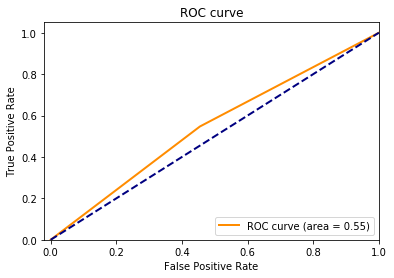

In [152]:
# #Plotting the ROC curve to assess model performance
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

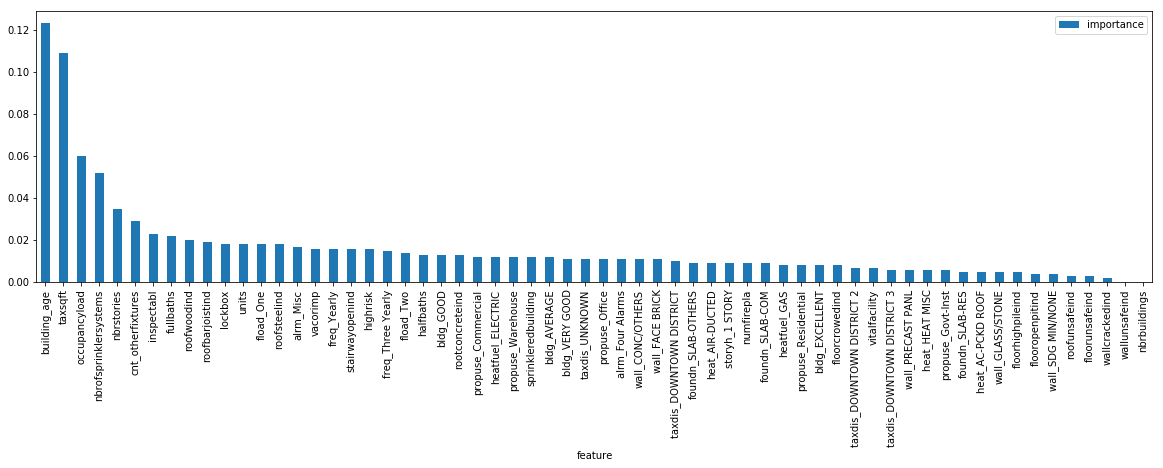

In [153]:
importances = pd.DataFrame({'feature':x_train.columns,'importance':np.round(model.feature_importances_,3)})

importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(20,5))

### Listing top features using Extra Trees

An extra-trees classifier : This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

The attribute "feature_importances_" lists out feature importances where the higher value denotes important features.

building_age                  0.036879
vacorimp                      0.035030
wall_FACE BRICK               0.034011
lockbox                       0.033589
fload_Two                     0.029812
taxdis_DOWNTOWN DISTRICT 3    0.028913
wall_PRECAST PANL             0.027557
units                         0.027426
storyh_1 STORY                0.027051
occupancyload                 0.025271
bldg_VERY GOOD                0.024808
bldg_GOOD                     0.024081
propuse_Residential           0.023542
nbrstories                    0.023518
cnt_otherfixtures             0.023323
propuse_Commercial            0.023189
sprinkleredbuilding           0.023084
foundn_SLAB-COM               0.022893
foundn_SLAB-OTHERS            0.022825
heat_AC-PCKD ROOF             0.021570
dtype: float64


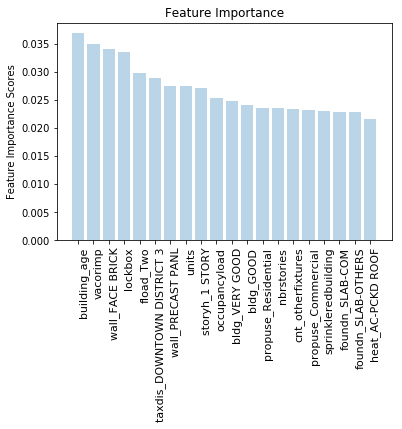

In [154]:
#Tree model for getting feature importance
clf = ExtraTreesClassifier()

impute_X = np.array(x_train)
impute_y = np.ravel(y_train)

clf = clf.fit(impute_X, impute_y)


UsedDf = x_train
important_features = pd.Series(data=clf.feature_importances_,index=UsedDf.columns)
important_features.sort_values(ascending=False,inplace=True)
#top 20 features
print (important_features[0:20])

#Plotting the top 20 features
y_pos = np.arange(len(important_features.index[0:20]))


plt.bar(y_pos,important_features.values[0:20], alpha=0.3)
plt.xticks(y_pos, important_features.index[0:20], rotation = (90), fontsize = 11, ha='left')
plt.ylabel('Feature Importance Scores')
plt.title('Feature Importance')

plt.show()

### Feature Importance

building_age                  0.041581
taxdis_DOWNTOWN DISTRICT 2    0.040244
propuse_Office                0.035531
vacorimp                      0.031867
propuse_Commercial            0.031283
wall_PRECAST PANL             0.029292
bldg_VERY GOOD                0.029279
units                         0.028270
storyh_1 STORY                0.026635
fload_Two                     0.026625
roofbarjoistind               0.026622
wall_FACE BRICK               0.026452
lockbox                       0.026092
nbrstories                    0.025081
occupancyload                 0.023891
propuse_Residential           0.023681
foundn_SLAB-COM               0.023222
taxdis_UNKNOWN                0.022236
nbrofsprinklersystems         0.021275
wall_CONC/OTHERS              0.020551
dtype: float64


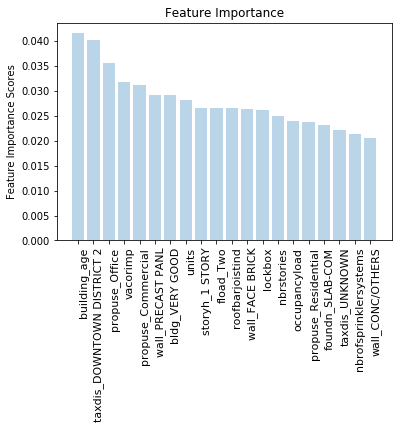

In [155]:
#Tree model for getting feature importance
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()

#imputed_fireVarTrain = fireVarTrain.fillna(method="ffill")
#imputed_traindata = traindata.fillna(method="ffill")

impute_X = np.array(x_train)
impute_y = np.ravel(y_train)

clf = clf.fit(impute_X, impute_y)

UsedDf = x_train
important_features = pd.Series(data=clf.feature_importances_,index=UsedDf.columns)
important_features.sort_values(ascending=False,inplace=True)
#top 20 features
print (important_features[0:20])

#Plotting the top 20 features
y_pos = np.arange(len(important_features.index[0:20]))

plt.bar(y_pos,important_features.values[0:20], alpha=0.3)
plt.xticks(y_pos, important_features.index[0:20], rotation = (90), fontsize = 11, ha='left')
plt.ylabel('Feature Importance Scores')
plt.title('Feature Importance')

plt.show()

In [156]:
from sklearn.ensemble import RandomForestClassifier
names = list(x_train)
rf = RandomForestClassifier(n_estimators=10, max_features=25)
rf.fit(x_train, y_train)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.12709999999999999, 'building_age'), (0.0504, 'wall_FACE BRICK'), (0.044499999999999998, 'nbrofsprinklersystems'), (0.043799999999999999, 'propuse_Commercial'), (0.035700000000000003, 'cnt_otherfixtures'), (0.0281, 'occupancyload'), (0.027699999999999999, 'fullbaths'), (0.027300000000000001, 'lockbox'), (0.0253, 'roofbarjoistind'), (0.025100000000000001, 'vacorimp'), (0.0246, 'taxsqft'), (0.024, 'wall_CONC/OTHERS'), (0.023199999999999998, 'taxdis_DOWNTOWN DISTRICT 3'), (0.022700000000000001, 'bldg_VERY GOOD'), (0.021600000000000001, 'propuse_Office'), (0.021100000000000001, 'nbrstories'), (0.019699999999999999, 'alrm_Misc'), (0.018800000000000001, 'freq_Three Yearly'), (0.018200000000000001, 'bldg_AVERAGE'), (0.017999999999999999, 'fload_One'), (0.0178, 'heat_AC-PCKD ROOF'), (0.017600000000000001, 'fload_Two'), (0.016899999999999998, 'roofwoodind'), (0.016500000000000001, 'wall_PRECAST PANL'), (0.015800000000000002, 'units'), (0.0149, 'inspectabl'), (

### ROC Curve

#### A Receiver Operating Characteristic (ROC) Curve is a way to compare diagnostic tests. It is a plot of the true positive rate against the false positive rate. A ROC plot shows:

#####     The relationship between sensitivity and specificity. For example, a decrease in sensitivity results in an increase in specificity.
#####     Test accuracy; the closer the graph is to the top and left-hand borders, the more accurate the test. Likewise, the closer the graph to the  
#####     diagonal, the less accurate the test. A perfect test would go straight from zero up the top-left corner and straight across the horizontal.
#####     The likelihood ratio; given by the derivative at any particular cutpoint.

In [157]:

### ROC plot preparation - roc_curve(true level,predicted outcome)
fpr, tpr, thresholds =roc_curve(y_test, lr_pred) 
roc_auc1 = auc(fpr, tpr)
print("Area under the ROC curve for Logistic Regression : %f" % roc_auc1)

fpr2, tpr2, thresholds2 =roc_curve(y_test, rf_pred)
roc_auc2 = auc(fpr2,tpr2)
print("Area under the ROC curve for Random Forest : %f" % roc_auc2)

fpr3, tpr3, thresholds3 =roc_curve(y_test, kn_pred)
roc_auc3 = auc(fpr3, tpr3)
print("Area under the ROC curve for KNN classification : %f" % roc_auc3)

fpr4, tpr4, thresholds4 =roc_curve(y_test, nb_pred)
roc_auc4 = auc(fpr4, tpr4)
print("Area under the ROC curve for Naive Bayes : %f" % roc_auc4)

fpr5, tpr5, thresholds5 =roc_curve(y_test, dt_pred)
roc_auc5 = auc(fpr5, tpr5)
print("Area under the ROC curve for Decision Tree : %f" % roc_auc5)

fpr6, tpr6, thresholds6 =roc_curve(y_test, pred_adaboost)
roc_auc6 = auc(fpr6, tpr6)
print("Area under the ROC curve for AdaBoost : %f" % roc_auc6)

fpr7, tpr7, thresholds7 =roc_curve(y_test, xgpred)
roc_auc7 = auc(fpr7, tpr7)
print("Area under the ROC curve for XG Boost : %f" % roc_auc7)

fpr8, tpr8, thresholds8 =roc_curve(y_test, gbpred)
roc_auc8 = auc(fpr8, tpr8)
print("Area under the ROC curve for Gradient Boosting : %f" % roc_auc8)

#fpr9, tpr9, thresholds9 =roc_curve(y_test, svm_pred)
#roc_auc9 = auc(fpr9, tpr9)
#print("Area under the ROC curve for SVM : %f" % roc_auc9)

Area under the ROC curve for Logistic Regression : 0.525234
Area under the ROC curve for Random Forest : 0.536248
Area under the ROC curve for KNN classification : 0.504852
Area under the ROC curve for Naive Bayes : 0.508070
Area under the ROC curve for Decision Tree : 0.547412
Area under the ROC curve for AdaBoost : 0.528788
Area under the ROC curve for XG Boost : 0.546208
Area under the ROC curve for Gradient Boosting : 0.543847


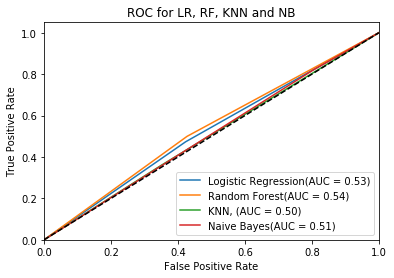

In [158]:

### Plot ROC plots
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression(AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2,tpr2,label='Random Forest(AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3,tpr3,label='KNN, (AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4,tpr4,label='Naive Bayes(AUC = %0.2f)' % roc_auc4)

#plt.plot(fpr5,tpr5,label='Support Vec Mach(AUC = %0.2f)' % roc_auc9)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for LR, RF, KNN and NB')
plt.legend(loc="lower right")
plt.show()

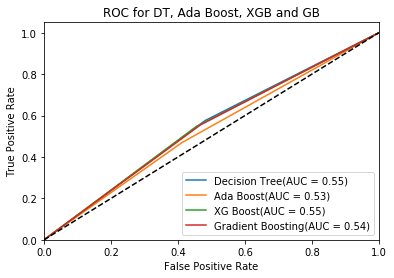

In [159]:
plt.figure()
plt.plot(fpr5,tpr5,label='Decision Tree(AUC = %0.2f)' % roc_auc5)
plt.plot(fpr6,tpr6,label='Ada Boost(AUC = %0.2f)' % roc_auc6)
plt.plot(fpr7,tpr7,label='XG Boost(AUC = %0.2f)' % roc_auc7)
plt.plot(fpr8,tpr8,label='Gradient Boosting(AUC = %0.2f)' % roc_auc8)

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.plot([0, 1], [0, 1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for DT, Ada Boost, XGB and GB')
plt.legend(loc="lower right")
plt.show()

### Model Evaluation

The code below is to evaluate various machine learning models which have been tried in the above steps. The mean accuracy and standard deviation of all the models are compared using stratified shuffle split as parameter for cross validation and plotted as a bar chart for visual comparison.

In [160]:
# stratified shuffle split of the data into 10 folds, with 20% of the data used in testing
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=2)

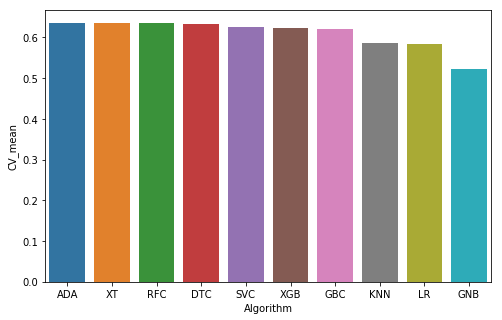

In [161]:
random_state=2

# store all the classifiers in a list
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(GaussianNB())

# store the cross validation accuracy results in a list
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(estimator=classifier,X=x_train,y=y_train,
                                      cv=sss,scoring='accuracy', n_jobs=-1))

# store the mean accuracy and standard deviation of the accuracy for each cross validation fold in lists    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# Combine the results lists in a dataframe
cv_results=pd.DataFrame({'CV_mean':cv_means , 'CV_std':cv_std , 'Algorithm':['SVC','DTC','RFC','KNN','LR',
                                                                             'ADA','XT','GBC','XGB','GNB']})
# sort the results by score
cv_results = cv_results.sort_values('CV_mean',ascending=False)

# plot the values for swift visual assessment of classifier performance
plt.subplots(figsize=(8,5))
sns.barplot('Algorithm','CV_mean',data=cv_results)

In [162]:
cv_results

,Algorithm,CV_mean,CV_std
5,ADA,0.635722,0.002430
6,XT,0.634547,0.002557
2,RFC,0.634380,0.003066
1,DTC,0.633751,0.002398
0,SVC,0.624755,0.001786
8,XGB,0.622265,0.001669
7,GBC,0.621959,0.002157
3,KNN,0.586669,0.014413
4,LR,0.583935,0.004316
9,GNB,0.521849,0.009701


In [163]:
x_test.to_csv("Results_test.csv")